# **Introduction to Python Programming 1**

**Please "Save A Copy" in your google drive and work with your own copy**

# **What is programming?**
1. A computer is a machine that executes programs.
2. A program is a description of a precise sequence of steps.
3. A computer executes the steps in a program to perform mechanical computations.
4. A programming language is designed for humans to easily read and write programs.
5. Python is a programming language

# **Section 1: Programming basics**


1. Writing your first piece of code
2. `print` statements
3. Comment statements
4. **7 Keyboard Shortcuts** that you **MUST** know (***You must familiarise yourself with these shortcuts***, please take a picture of it and store it in your phone for your easy reference!)

|S/N: | Shortcuts | Description |
| --- | --- | --- |
|1.| Ctrl + Enter | Run Code Cell |
|2.| Ctrl + a | Select everything |
|3.| Ctrl + c | Copy |
|4.| Ctrl + v | paste |
|5.| Ctrl + / | Comment/Uncomment |
|6.| Ctrl + [ | Dedent (Moving your code 2 or 4 spaces **BACK**, depending on your settings) |
|7.| Ctrl + ] | Indent (Moving your code 2 or 4 spaces **FORWARD**, depending on your settings)|

1. Programming is not just about mathematics.
2. Mathematics make it possible for machines to compute, and thus we use math to express what we want to achieve.
3. We use programming to solve many problems in real-life, often 'qualitative' in nature
4. One of which is dealing with text



Open a new code box for each of the following:
1. `print('Hello world'!)`
2. `print('Hello','world!')`
1. `print('My life is a great adventure and so much fun!')`
2. `print('My life is a great adventure', 'and', 'so much fun!')`




Anything within 'quotes' or "double quotes" in python will be treated as a string / character / text.

To print it out, use the print() function. Functions are like 'recipes' that tell python to do something for you.

Functions usually have a name like *print*, and then followed by parathesis (): *print()*.

The recommended way to print a string is:

1. Type print()
2. Within the parathesis, put in a quote '. Python will automatically insert two single quotes and put your cursor within them.
3. Type your text


#### **Exercise 1.1**

In [1]:
print('Hello world!')

Hello world!


Comments are important to inform the reader what does the block of code do. It's highly recommended that you comment before you write any code, for others and yourself (when you come back to the codes again)

Comments are initiated in python via the hex (hashtag) character #.

Any thing after # will be treated as a comment and will not be executed.



In [ ]:
# this is a comment
#### multiple # also denotes comments

''' triple single quotes can sometimes be treated as comments as well '''
""" like this as well """

# **Section 2: Making your codes reusable**


## 2.1 Variable assignment
In programming, we are concerned about improving the quality-of-life (QOL) of coders and readers. 2 important QOL principles that we are going to learn here are:

1.   Naming your steps
2.   Reusable operators

We can achieve these QOL principles by using variable assignment. Variable assigns values to names. Always remember to use names that are easy to understand.


#### Rules of Variable Names

1. Variable names must start with an alphabet (a to z), they cannot start with numbers (0-9) or special characters (!@#$%)

2. Variable names must be 1 continuous 'word' without breaks. *num of words* do not work. *num_of_words* is alright.

3.   Variable names are CASE-SENSITIVE. *num_of_words* is not the same as *Num_of_words*, and both of them are not the same as *Num_Of_Words*.

4. The recommended way to link up words in a variable name is to use underscore _. We do not usually use camelcase (numOfWords).

4.   When variables are assigned a value, Python understands that it should act on the values underlying the variables.

5.   We can thus use operators on variable names to obtain our desired solution.

**Useful Material:**

http://pythontutor.com/visualize.html#mode=edit

In [ ]:
# make sure you have defined the variables before you call it
variable_one =

# writing this way ensures whenever we change variable_one's value
# variable_two's code don't have to be modified
variable_two =

In [ ]:
print()
print()

## 2.2 Mathmatical Operators
In the above exercise, we covered the addition operator.

There are other common operators as well (***You must familiarise yourself*** with these operators, please take a picture of it and store it in your phone for your easy reference!):

|S/N|Description|Operator| What it does?|
|---|---|---|---|
|1.|Addition| +| Add elements (integer & float) up **OR** Concatenates elements (everything else except integer & float)
|2.|Subtraction| -| Subtracts right hand element from left hand element.
|3.|Multiplication| *| Multiply elements (integer & float) **OR** Make copies of the element (everything else except integer & float)
|4.|Division| /| Outputs a floating point number
|5.|Power/Exponent| **| Raises the left element to the power of the right element
|6.|Modulo| %| Retrieves the remainder of a division
|7.|Floor division| //| Outputs the Quotient


## **What is Quotient, Divisor & Remainder?**

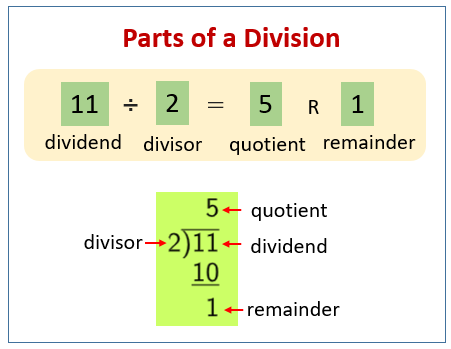

#### **Exercise 2.2.1**
**Simple Arithmetic Operations**

**Your task:** Provide the answers to the following questions using arithmetic operators. Show your codes below.

Question 1) Subtract 620 from 991.

Question 2) Calculate 4 to the power of 3.

Question 3) Divide 39420 by 4.

Question 4) Sum up all the whole numbers from 1 to 10.

Question 5) What is the remainder when 70 is divided by 6?

In [ ]:
# Type your codes here.

question_1 = 991 - 620

question_2 = 4 ** 3

question_3 = 39420/4

question_4 = 550

question_5 = 70 % 6

print("The output for Q1 is:", question_1) # Repeat this statement for the rest of the questions
print("The output for Q2 is:", question_2) # Repeat this statement for the rest of the questions
print("The output for Q3 is:", question_3) # Repeat this statement for the rest of the questions
print("The output for Q4 is:", question_4) # Repeat this statement for the rest of the questions
print("The output for Q5 is:", question_5) # Repeat this statement for the rest of the questions

#### **Exercise 2.2.2**
Colin has $30000 dollars. He puts it into a savings account with 1.8% simple interest. How much money will he have after a year?



In [ ]:
# Write your code here.
total =

print('Colin will have $', total ,'after one year.')

#### **Exercise 2.2.3**

Sam is baking cookies to sell at home. The cost of his ingredients for 1 jar of cookies are as follows:

1. Flour: \$1
2. Eggs: \$2.30
3. Chocolate Chips: \$7.99
4. Baking Soda: \$2.55
5. Sugar: \$2
6. Milk: \$4.10

What price should Sam sell his cookies for if he wishes to make a 20% profit?

Use variable assignment and expressions to solve this.

In [ ]:
# Write your code here
Flour = 1
Eggs = 2.30
Chocolate_Chips = 7.99
Baking_Soda = 2.55
Sugar = 2
Milk = 4.10

price =

print("The total price is $", price)

#### **Exercise 2.2.4**

Exercise 2.4 is broken down into 2 practices, try it on your own! The hints are given, use them as a guide when you create your variables.

**Question Part One:**

John brought 48 apples to class, which has 21 students. He decides to divide the apples evenly and completely (i.e. no slicing) to all the students in the class. Any remainder will be given to the instructor.

1.   How many apples do each student get?
2.   How many apples will the instructor get?

**Your task:**

Use variables assignment and expressions to solve this, and print your answer without hardcoding the values.

**Hints:**

1. Assign no_of_apples a value of 48
2. Assign no_of_students a value of 21
3. Compute no_of_apples_per_student given each student receives same number of apples
(i.e. use int() or //)
4. Compute no_of_extra_apples (i.e. use modulo %)
5. Assign no_of_apples_for_instructor appropriately
6. Print the result in the form of "The number of apples per student in a class of X is Y."
7. Print the result in the form of "The number of apples given to the instructor is Z."



In [ ]:
# Create and assign values to the 2 variables - no_of_apples & no_of_students
no_of_apples = 48
no_of_students = 21

no_of_apples_per_student =
print(no_of_apples_per_student)

# The answer will be a float if the division is not complete.
# Students should be getting full apples instead of slices of the remaining apples.
# Thus we convert the float to an integer by calling the int() function.
# Int function gives the floor of the float (i.e. round down).

# Number of Apples Per Student is?
#print(f'the number of apples each student gets is {no_of_apples_per_student}')


# Number of Extra Apples?
no_of_extra_apples =
no_of_apples_to_instructor =

# Print the results nicely as instructed above.
print('the number of apples the instructor gets is', no_of_apples_to_instructor)
# print(f'the number of apples the instructor gets is {no_of_apples_to_instructor}')






In [ ]:

no_of_apples = 48
no_of_students = 21

## Question 1
student_get = 48 // 21


## Question 2
remain = no_of apples % no_of_students

print (student_get)

SyntaxError: invalid syntax (<ipython-input-1-80b52847cee6>, line 9)

**Question Part Two:**
- John realized that he has another 2 apples in his bag and decided to give them to the instructor after the class. How many apples will the instructor get?
- Print the result in the form "The number of apples given to the instructor is X".
- **Challenge:** Using the final value above with `+=` symbol. The syntatical meaning of `+=` is as follows:

|  | | |
|---|---|---|
| X+=1 | =>  | X+1|



In [ ]:
# Here, we demonstrate a short form operator
# that adds, subtract, divide, or multiply a variable's existing value with the new value.
#no_of_apples_to_instructor = no_of_apples_to_instructor + 2

no_of_apples_to_instructor

print(no_of_apples_to_instructor)


#### **Exercise 2.2.5**

Convert kilograms to pounds.



The steps are as follows:

Multiply the weight in kilograms by 2.2
Trying converting kg to pounds of:

1) 80kg

2) 57kg

Subsequently, print out the statements for each of the conversion as follows `"The weight of ___ Kg in pounds is: ______"` (*The blanks are to be filled with variables.*)

In [ ]:
# Write your code here

### Question 1: ###
kg_weight = 80
pound_weight =
question_part_1 =
print("The weight of", kg_weight ,"Kg in pounds is:", question_part_1)

### Question 2: ###
kg_weight = 57
pound_weight =
question_part_2 =
print("The weight of", kg_weight ,"Kg in pounds is:", question_part_2)

## 2.3 Comparison Operators
*Credits: https://www.tutorialspoint.com/python/python_basic_operators.htm*

These operators compare the values on either sides of them and decide the relation among them. The output will **always be a Boolean value** - `True` or `False` value.

For this example, we will be setting our variables as follows (please look at them very carefully):

```
a = 10
b = 10
c = 20
```

|Operator|	Description|	Example| Output
|---|---|---|---|
|==|If the values of two operands are **Equal**, then the condition becomes True|`a==b`| True
|==|If the values of two operands are **NOT Equal**, then the condition becomes False|`a==c`| False
!=|	If values of two operands are **NOT Equal**, then condition becomes True|	`a != c` |True
!=|	If values of two operands are **Equal**, then condition becomes False|	`a != b` |False
\>|If the value of **left** operand is **Greater** than the value of **right** operand, then condition becomes True | `c > a`| True
\<|If the value of **left** operand is **less than** the value of **right** operand, then condition becomes True | `a < c`| True
\>=|If the value of **left** operand is **greater than or equal** to the value of **right** operand, then condition becomes True|`c >= a`|True
\<=|If the value of **left** operand is **less than or equal** to the value of **right** operand, then condition becomes True.|`a <= c`|True


#### **Exercise 2.3.1**
Tom has $10 and wants to buy the following items:

Notepad - $2.30

Iced Coffee - $3.45

Printing Fees - $5

Does Tom have enough money? Calculate using variable assignment and evaluate using Boolean expressions.

In [2]:
notepad_price = 2.30
iced_coffee = 3.45
printing_fees = 5
tom_cash = 10

sum_cost =

enough_money =
not_enough_money =

print('Did Tom have enough money? Answer:', enough_money)
print('Did Tom not have enough money? Answer:', not_enough_money)

SyntaxError: invalid syntax (ipython-input-2-3622645131.py, line 6)

#### **Exercise 2.3.2**

We would like to check if someone is overweight based on the Body Mass Index (BMI). A BMI above 23 usually indicates that a person's weight is outside the healthy range for his/her height.

BMI is calculated by taking a person's weight (kg) and dividing by the square of his/her height (m).

Given that Jerry is 70kg and 1.7m, what is his BMI?

Is Jerry overweight?


In [3]:
weight = 70
height = 1.7
overweight_bmi = 23

bmi = 123
bmi_status =

print('Jerry has a BMI of', bmi)
print('Jerry is overweight?:', bmi_status)

SyntaxError: invalid syntax (ipython-input-3-2672329639.py, line 5)